# Module 1, Notebook 1 - Wrangling ADNI Imaging and Outcome Data  

> ### **(30 points + 3 extra credit points) || Due by **





## Instructions

Please make a copy and rename it with your name (ex: Module1_NB1_Ilmi_Yoon). All grading points should be explored in the notebook but some can be done in a separate pdf file. 

*Graded questions will be listed with "Q:" followed by the corresponding points.* 

You will be submitting **a pdf** file containing **the url of your own Module1_NB1.**


---



# Introduction

## 1. Mounting and Accessing the Data

In [ ]:
import numpy as np
import os
from pathlib import Path
import glob
import pandas as pd
from collections import Counter
import math
from tqdm import tqdm

In [ ]:
from google.colab import drive

Because we are working on data stored in Google Drive, the following steps will need to be taken: 
1. Mount Google drive through using drive.mount('/content/drive')
2. Ceate a shortcut your personal Google Drive home directory to the location where the data is through: 
  * Navigating to https://drive.google.com/
  * Click "My Drive" 
  * Click the "+ New" button, add folder, and name it Data_Shortcut. This will be the place you can access to the data.
  * From drive.google.com, navigate to "Shared with me", click on rev3, CS509_Data
  * Right click on Module1_ADNI and click "Add shortcut to drive" 
  * Add to the Data_Shortcut you just created in MyDrive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = Path('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/')

We want to make sure we've mounted the data properly and that there are a good number of patients in the PET data folder: 

In [ ]:
num_pts = len(os.listdir(Path(DATA_PATH,'MRI', 'ADNI')))
print(f'There are {num_pts} patients in the folder')

There are 1460 patients in the folder


In [ ]:
print('There are ' + str(len(glob.glob(str(Path(DATA_PATH, 'MRI', 'ADNI', '*', '*')))))+ ' files in the in the patient folders')

There are 3149 files in the in the patient folders


So there are multiple MRI images files in each folder. Let's see what kinds of PET there are. 

## 2. Investigating the types of imaging data

In [ ]:
Counter([x.split('/')[-1] for x in glob.glob(str(Path(DATA_PATH, 'MRI','ADNI', '*', '*')))]).most_common()[:15]

[('Sagittal_3D_FLAIR', 400),
 ('Field_Mapping', 359),
 ('MPRAGE', 346),
 ('Axial_PD-T2_TSE', 260),
 ('Axial_T2_Star', 244),
 ('Axial_PD_T2_FSE', 242),
 ('HighResHippocampus', 118),
 ('Axial_T2_STAR', 112),
 ('3-plane_localizer', 98),
 ('Axial_3TE_T2_STAR', 87),
 ('Axial_3D_PASL__Eyes_Open_', 80),
 ('Perfusion_Weighted', 77),
 ('Head,3-P,2D,LOCALIZER', 70),
 ('FSE_PD_T2', 58),
 ('Accelerated_Sag_IR-FSPGR', 54)]

In [ ]:
for patient in os.listdir(DATA_PATH/'MRI'/"ADNI"): 
  if len(os.listdir(DATA_PATH/'MRI'/'ADNI'/patient)) > 4: 
    print(patient, len(os.listdir(DATA_PATH/'MRI'/'ADNI'/patient)))

153_S_6450 6
002_S_6404 5
109_S_6363 5
109_S_6300 5
016_S_6904 5
016_S_6926 5
016_S_6939 5
016_S_6943 5
016_S_6941 5
941_S_6017 5
099_S_6025 5
941_S_6044 6
099_S_6097 5
067_S_6117 5
007_S_6120 5
130_S_6027 5
129_S_6146 5
116_S_6119 5
153_S_6237 5
003_S_6256 5
153_S_6274 6
041_S_6226 5
052_S_6305 5
153_S_6336 5
020_S_6358 5
016_S_6381 5
067_S_6443 5


Let's use the first patient and compare 

In [ ]:
patient_id_test = '153_S_6450'
PATH_TO_MRI = Path(DATA_PATH, 'MRI','ADNI')
os.listdir(PATH_TO_MRI/patient_id_test)

['Sagittal_3D_FLAIR',
 'Field_Mapping',
 'Axial_T2_STAR',
 'Axial_rsfMRI__Eyes_Open_',
 'Axial_DTI_FA',
 'HighResHippocampus']

In [ ]:
image_type_to_test = 'Axial_T2_STAR'

In [ ]:
## Looking at the files, picking one of the descriptions above and looking at the file structure: 
glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, '*', '*', '*')))[0]

'/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/MRI/ADNI/153_S_6450/Axial_T2_STAR/2018-07-05_09_38_04.0/I1017657/ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135823820_27_S701813_I1017657.dcm'

Looks like the structure is as follows: 


`<root_path>/Module1_ADNI/PET/<patient_id>/<image_type>/<date>/<Series>/<full_image_name>.dcm`

Let's see how many dates, series, and DICOM images there are in this particular image_type: 



In [ ]:
print('The number of dates in this image type is: '+ str(len(glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, '*', ))))), 
      ' and they are: ', [x.split('/')[-1] for x in glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, '*', )))])

The number of dates in this image type is: 1  and they are:  ['2018-07-05_09_38_04.0']


In [ ]:

date_test = [x.split('/')[-1] for x in glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, '*', )))][0]
image_series_test = [x.split('/')[-1] for x in glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test,'*' )))][0]


In [ ]:
## In a single series, it looks like the DICOMs are numbered by their slice based on third to last element in the slice name.
os.listdir(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test,image_series_test ))[:30]

['ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135823820_27_S701813_I1017657.dcm',
 'ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135819688_8_S701813_I1017657.dcm',
 'ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135821463_19_S701813_I1017657.dcm',
 'ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135823995_28_S701813_I1017657.dcm',
 'ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135821626_20_S701813_I1017657.dcm',
 'ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135819313_7_S701813_I1017657.dcm',
 'ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135820115_15_S701813_I1017657.dcm',
 'ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135820963_13_S701813_I1017657.dcm',
 'ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135821124_14_S701813_I1017657.dcm',
 'ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135823155_29_S701813_I1017657.dcm',
 'ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_20180706135819249_1_S701813_I1017657.dcm',
 'ADNI_153_S_6450_MR_Axial_T2_STAR__br_raw_201

In [ ]:
len(os.listdir(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test,image_series_test )))

44

These files all have the extension ".dcm", which means that it's a DICOM file. These types of files have both pixel data and meta-data associated with the pixel data (image). Therefore, they require a special reader in python. A quick google search will tell you to use pydicom, but Colab doesn't have that pre-installed. We'll install it below: 

In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 4.2 MB/s 


In [ ]:
import pydicom
import matplotlib.pyplot as plt

In [ ]:
## Using the _30_ tag as a potential indicator that it's the slice at the center of the volume
first_dicom_dataset = pydicom.dcmread(glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test, image_series_test, '*_22_*')))[0])

In [ ]:
## Looking at the components of a Dicom image/dataset: 
first_dicom_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.124.113543.6006.99.01970106567448283687
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.16.124.113543.6006.99.08543681504287939592
(0002, 0016) Source Application Entity Title     AE: 'ISHAREOUT_AE'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 1010
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS2D']
(0008, 0013) Instance Creation Time              TM: '101033.302000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(00

When you view the variable, you'll notice different numerical "tags". Each tag keeps a unique data field. Some important DICOM data fields for MRI images include: 

*   Series Description
*   Pixel Data 

You can usually find nearly any information you're looking for with respect to the image acqusition in these DICOM fields. Since some of these are manually input into the scanner, it is possible that the data field is subject to error. Let's access some of the tags and then look at the image: 


In [ ]:

## If we want to know the manufacturer that this DICOM image was acquired at, 
## you can access a tag by its numerical value like this: 
first_dicom_dataset[0x8, 0x70]
## Note that we have to use 0x<number> format; otherwise Python won't know 
## the 0s preceding the code exist.

(0008, 0070) Manufacturer                        LO: 'SIEMENS'

In [ ]:

## You can also use the name of the element: 
first_dicom_dataset['Manufacturer']

(0008, 0070) Manufacturer                        LO: 'SIEMENS'

In [ ]:
## Or if you want the value only: 
first_dicom_dataset.Manufacturer

'SIEMENS'

Now let's look at the image itself, which is located at the "pixel_array" element of the DICOM dataset: 

In [ ]:
first_dicom_dataset.pixel_array.shape

(256, 256)

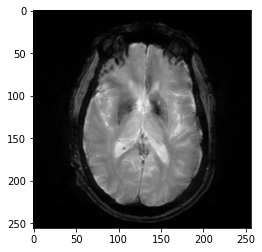

In [ ]:
plt.imshow(first_dicom_dataset.pixel_array, cmap = 'gray')

Let's confirm that the `_22_` number in the file name corresponds to the slice number. To do that, let's load the dicom slice datasets into a dictionary with the key as this identifier, then sort the keys & plot the slices: 

In [ ]:
def read_all_dicom_slices(dicom_directory, 
                         ):
  """
  Will read in the images from a single dicom folder and return a dictionary of 
  those images with the key as the presumed slice number, and the value being the pixel array. 
  
  dicom_directory: Path or string that leads to the folder containing the slices 

  """
  dicom_image_dict = {}
  for image in glob.glob(str(Path(dicom_directory, '*'))): 
    key = image.split('/')[-1].split('_')[-3]
    dicom_image_dict[key]= pydicom.dcmread(image)
  return dicom_image_dict

In [ ]:
first_dicom_dir =  Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test, image_series_test)
first_dicom_volume = read_all_dicom_slices(first_dicom_dir)


In [ ]:
def visualize_dicom_volume(dicom_volume: dict): 
  """
  Takes a dicom volume, gives them the proper titles. 
  dicom_volume,  e.g. {'1': <pixel_data>, ...}
  output is to plot an appropriate size image of the voulme that one is interested in. 
  """
  num_rows = math.ceil(len(dicom_volume.keys())/5)
  keys_sorted = [str(x) for x in sorted([int(x) for x in list(dicom_volume.keys())])]
  plt.figure(figsize = (20, 15*num_rows))
  for i, key in enumerate(keys_sorted): # iterates through the dictionary, while the enumerate function keeps track of the index with i
      plt.subplot(5*num_rows,5,i+1)    # the number of images in the grid 
      value = dicom_volume[key]
      img = value.pixel_array
      plt.imshow(img, cmap= 'gray')
      plt.axis('off')
      plt.title(key)
  plt.show()

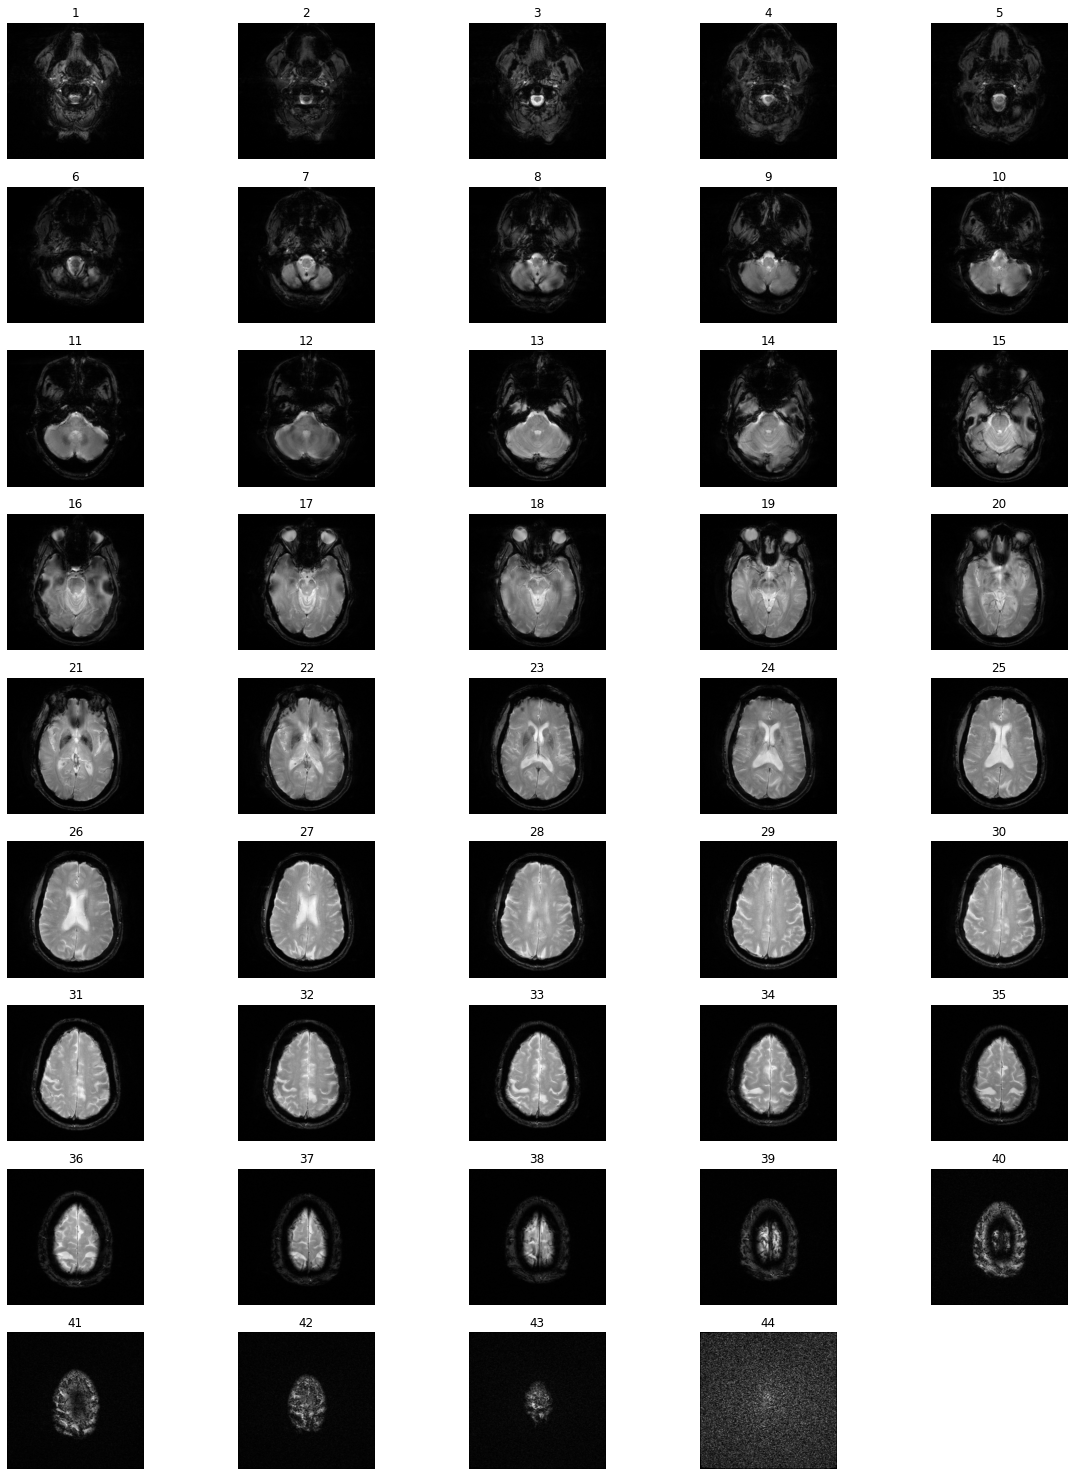

In [ ]:
visualize_dicom_volume(first_dicom_volume)

Let's look at another image type to test: 

In [ ]:
os.listdir(PATH_TO_MRI/patient_id_test)

['Sagittal_3D_FLAIR',
 'Field_Mapping',
 'Axial_T2_STAR',
 'Axial_rsfMRI__Eyes_Open_',
 'Axial_DTI_FA',
 'HighResHippocampus']

In [ ]:
image_type_to_test = 'Axial_rsfMRI__Eyes_Open_'
date_test = [x.split('/')[-1] for x in glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, '*', )))][0]
image_series_test = [x.split('/')[-1] for x in glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test,'*' )))][0]
second_dicom_dir =  Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test, image_series_test)
second_dicom_volume = read_all_dicom_slices(second_dicom_dir)


In [ ]:
second_dicom_volume

{}

Looks like there's actually nothing in this directory! Let's try the 3rd. 

In [ ]:
image_type_to_test = 'Field_Mapping'
date_test = [x.split('/')[-1] for x in glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, '*', )))][0]
image_series_test = [x.split('/')[-1] for x in glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test,'*' )))][0]
third_dicom_dir =  Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test, image_series_test)
third_dicom_volume = read_all_dicom_slices(third_dicom_dir)


In [ ]:
visualize_dicom_volume(third_dicom_volume)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image_type_to_test = 'Axial_T2_STAR'
date_test = [x.split('/')[-1] for x in glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, '*', )))][0]
image_series_test = [x.split('/')[-1] for x in glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test,'*' )))][0]
fifth_dicom_dir =  Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test, image_series_test)
fifth_dicom_volume = read_all_dicom_slices(fifth_dicom_dir)


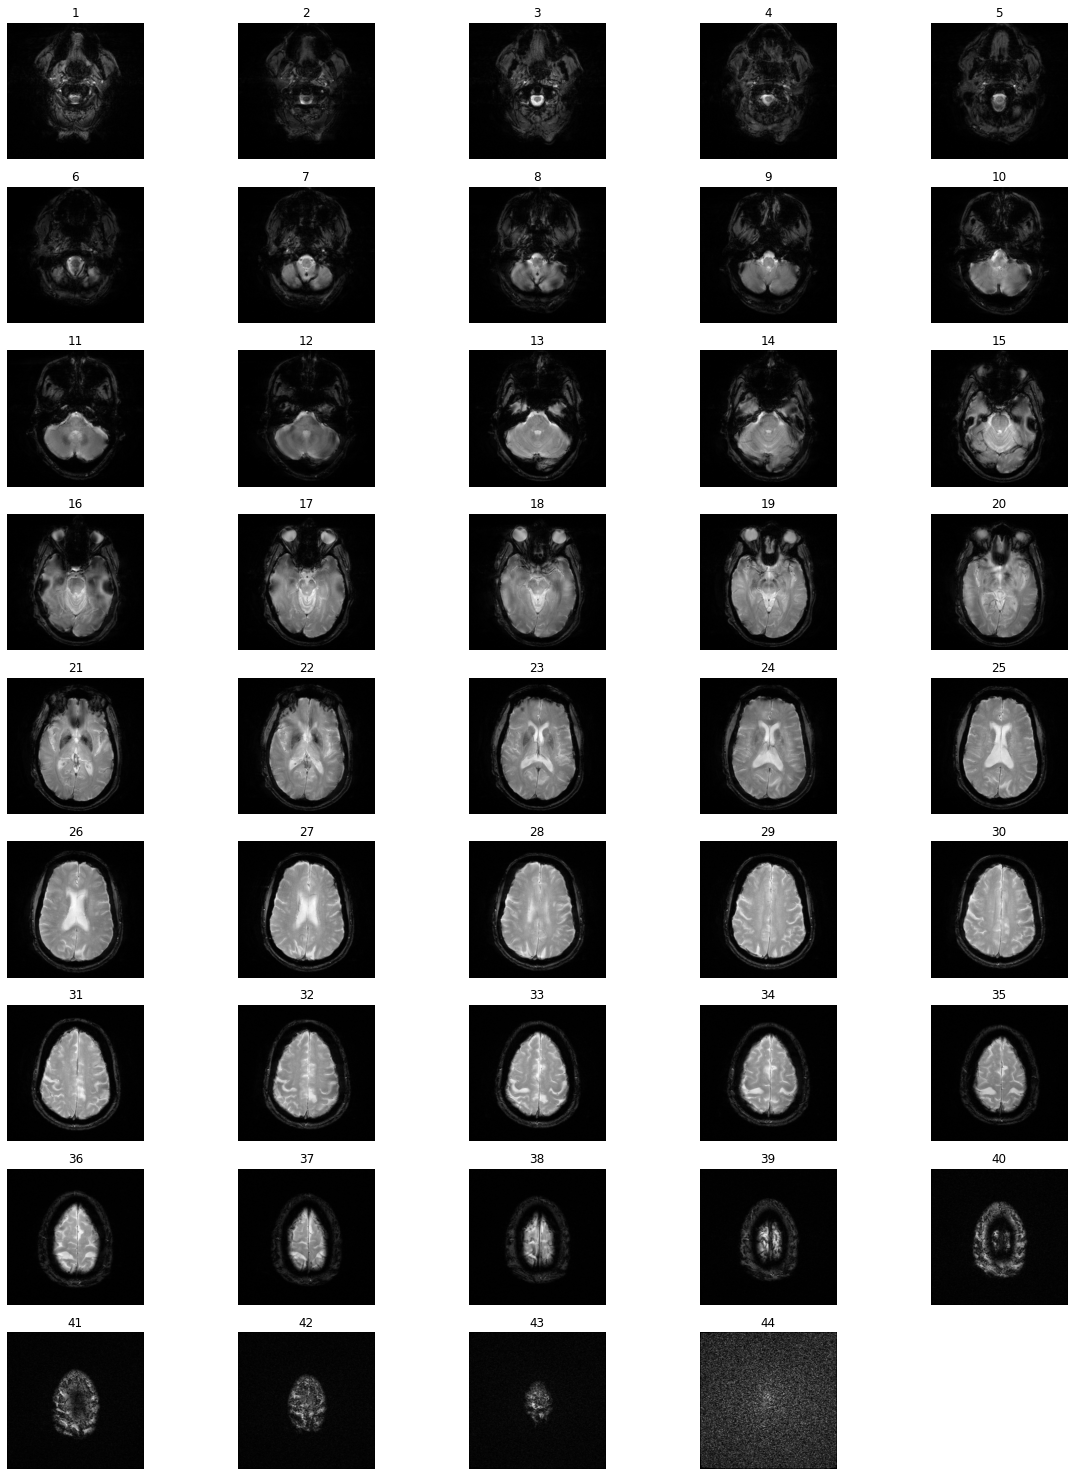

In [ ]:
visualize_dicom_volume(fifth_dicom_volume)

In [ ]:
image_type_to_test = 'Axial_DTI_FA'
date_test = [x.split('/')[-1] for x in glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, '*', )))][0]
image_series_test = [x.split('/')[-1] for x in glob.glob(str(Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test,'*' )))][0]
fourth_dicom_dir =  Path(PATH_TO_MRI,patient_id_test,image_type_to_test, date_test, image_series_test)
fourth_dicom_volume = read_all_dicom_slices(fourth_dicom_dir)


In [ ]:
fourth_dicom_volume

{}

# Finding the center slices of all the MRI volumes: 

Normally, I'd just glob the whole thing, but it's running too slow so I'm using a bit of a process with tqdm to show the status bar to see how long it will take: 

In [ ]:
path_list_all_mri = []
for patient in tqdm(os.listdir(PATH_TO_MRI)): 
  patient_mri = glob.glob(str(Path(PATH_TO_MRI, patient, '*', '*', '*')))
  path_list_all_mri +=patient_mri

100%|██████████| 1460/1460 [06:21<00:00,  3.82it/s]


In [ ]:
path_list_all_mri[0]

'/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/MRI/ADNI/067_S_6474/Field_Mapping/2018-06-27_14_43_31.0/I1014592'

In [ ]:
num_slices = len(os.listdir(path_list_all_mri[0]))
num_slices

54

In [ ]:
## Here, we want to go through the path list of uniform voxels and find the middle "center" slice of the volume
## and record the path to it: 
middle_slices = []
for path_to_mri in tqdm(path_list_all_mri): # Using the tqdm package to show a status bar based on how quickly the process is running
  num_slices = len(os.listdir(path_to_mri))
  middle_slice = str(num_slices//2)
  middle_slice_1 = str(num_slices//2+1)
  middle_slice_neg1 = str(num_slices//2-1)
  # print(middle_slice)
  if len(glob.glob(path_to_mri+'/*_'+middle_slice+"_*")) > 0: 
    middle_slices.append(glob.glob(path_to_mri+'/*_'+middle_slice+"_*"))
  elif len(glob.glob(path_to_mri+'/*_'+middle_slice_1+"_*")) > 0:
    middle_slices.append(glob.glob(path_to_mri+'/*_'+middle_slice_1+"_*"))
  elif len(glob.glob(path_to_mri+'/*_'+middle_slice_neg1+"_*")) > 0:
    middle_slices.append(glob.glob(path_to_mri+'/*_'+middle_slice_neg1+"_*"))
  else: continue
    # print(path_to_mri)

100%|██████████| 4093/4093 [00:26<00:00, 155.46it/s]


In [ ]:
len(middle_slices)

3272

Creating a CSV file from these middle slices: 

In [ ]:
middle_slice_df = pd.DataFrame({'FILEPATH_MIDDLE_SLICES': [x[0] for x in middle_slices]})

In [ ]:
middle_slice_df.loc[0, 'FILEPATH_MIDDLE_SLICES']


'/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/MRI/ADNI/067_S_6474/Field_Mapping/2018-06-27_14_43_31.0/I1014592/ADNI_067_S_6474_MR_Field_Mapping__br_raw_20180628122509805_27_S699432_I1014592.dcm'

In [ ]:
middle_slice_df['SLICE_NUM'] = [x.split('_')[-3] for x in middle_slice_df.FILEPATH_MIDDLE_SLICES]
middle_slice_df.SLICE_NUM.value_counts()

80      672
27      585
22      423
24      368
25      261
15      148
1       139
26      125
52       73
91       69
2        67
98       57
85       51
28       43
20       34
40       33
29       20
92       18
30       14
1200     10
14       10
87        7
4728      6
23        4
120       4
11        3
13        3
12        3
7         2
5         2
1360      2
70        2
6         2
21        1
4056      1
64        1
3415      1
8         1
600       1
1440      1
9         1
180       1
3587      1
18        1
17        1
Name: SLICE_NUM, dtype: int64

In [ ]:
middle_slice_df['MRI_TYPE'] = [x.split('/')[9] for x in middle_slice_df.FILEPATH_MIDDLE_SLICES]

In [ ]:

middle_slice_df.MRI_TYPE.value_counts()

Field_Mapping               514
MPRAGE                      416
Sagittal_3D_FLAIR           402
Axial_PD_T2_FSE             351
Axial_T2_Star               248
                           ... 
Axial_PD-T2_TSE_NO_ANGLE      1
ADNI_new___Double_TSE2        1
ADNI_______DOUBLE_TSE2        1
ORIG_Sagittal_3D_FLAIR        1
Axial_DTI_FA                  1
Name: MRI_TYPE, Length: 86, dtype: int64

In [ ]:
os.makedirs(Path(DATA_PATH.parent, 'csvs'), exist_ok = True)

In [ ]:
middle_slice_df.to_csv(Path(DATA_PATH.parent, 'csvs', 'ADNI_MRI_MiddleSlices.csv'))